In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# Load dataset
df = pd.read_csv(r'C:\Users\HP\Downloads\INM701_CW-main\Data\data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## 1. Data exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [4]:
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

As observed, all features are numerical and all the columns have no missing data. But, as always, it's a good idea to do some visualizations to see if there are any interesting trends or ideas we should keep in mind while we work. First, let's take a look at how many firms are bankrupt, and how many are not.

In [5]:
df['Bankrupt?'].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

We only have 220 firms that are bankrupt, while there are 6599 firms that are not bankrupt. The bankruptcy firms only take 3.2% of all firms.

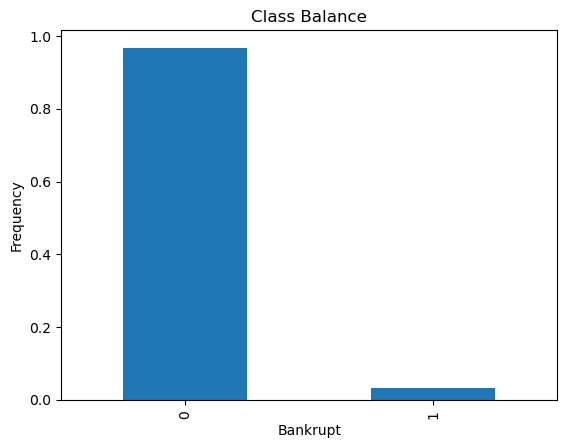

In [7]:
df['Bankrupt?'].value_counts(normalize=True).plot(
    kind = 'bar',
    xlabel = 'Bankrupt',
    ylabel = 'Frequency',
    title = 'Class Balance'
);

We can see that our data is imbalanced, so we have to resample the data to forecast in order to make sure that we can improve f1 score.

Two possible ways that we can resample the data:

1. OverSampling:

- Using RandomOverSampler/SMOTE

2. UnderSampling:

- Using RandomUnderSampler/ENN

<AxesSubplot:>

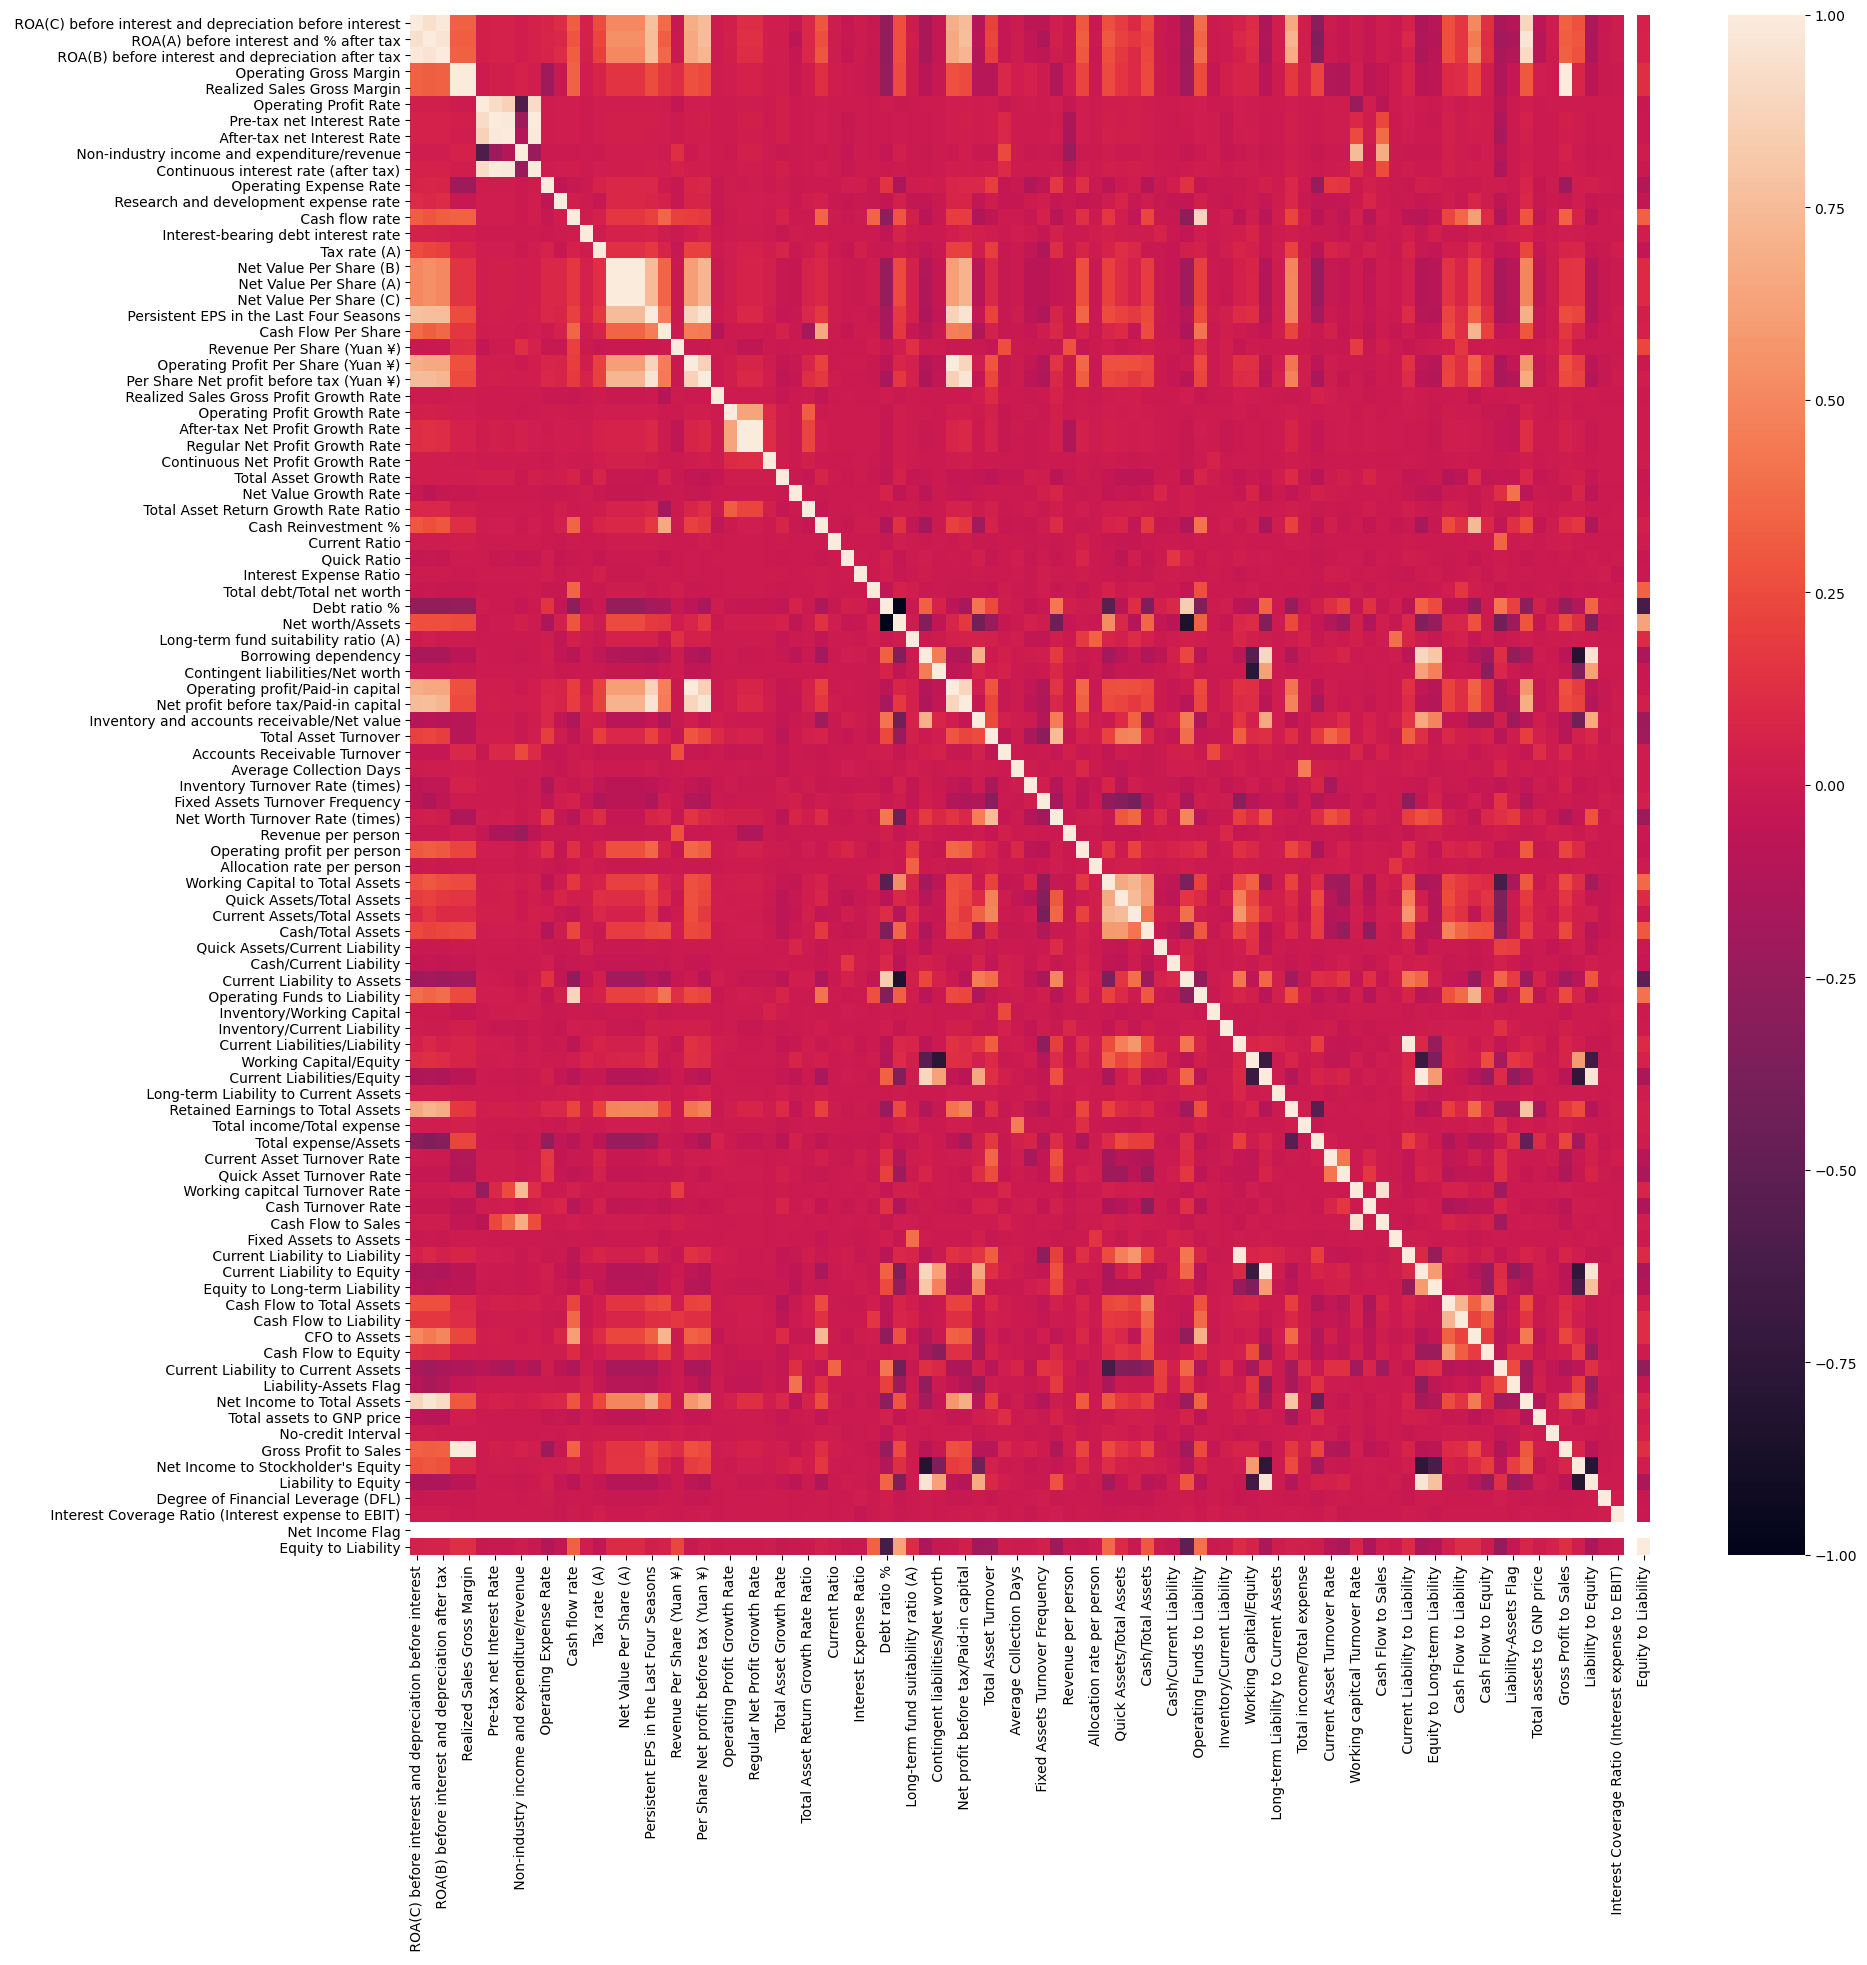

In [8]:
plt.figure(figsize=(20,20))
corr = df.drop(columns = "Bankrupt?").corr()
sns.heatmap(corr)

* All three ROAs (ROA(a), ROA(b) and ROA(c) are positively correlated amongst each other. 
* Net value per share A,B and C are also highly correlated between each other.
* ' Debt ratio %', ' Net worth/Assets' are negatively correlated.
* After tax net interest rate and pre tax net interets rate are also highely correlated.
* ' Non-industry income and expenditure/revenue' is negatively correlated with Operating Profit Rate.
* ' Operating Profit Growth Rate',' After-tax Net Profit Growth Rate' and ' Regular Net Profit Growth Rate' are also highely correlated.
* ' Per Share Net profit before tax (Yuan ¥)' and ' Persistent EPS in the Last Four Seasons' are highely correlated.

**Similarly there are a lot of multicollinearity in the dataset.
So I can conclude from here that Regression model will not work properly on this dataset. This is a classification problem.**

## 2. Feature Selection

In [9]:
# Extract X and y
target = "Bankrupt?" 
X = df.drop(columns=target) # features except for target
y = df[target] # target

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # random split

In [11]:
# impute missing values if any, in this data no missing values so it will not affect the results
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

## 3. Resample using SMOTE

In [74]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

## 4. Model Selection

I used XGBoost, LightGBM, CatBoost and Random Forest

In [75]:
# XGBoost model
def create_xgb_model():
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False
    )
    return model

# LightGBM model
def create_lgb_model():
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss'
    )
    return model

# CatBoost model
def create_cb_model():
    model = cb.CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='Logloss',
        verbose=0
    )
    return model

# RandomForest model
def create_rf_model():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    return model

## 5. Selecting the best model based on F1 score

Training XGBoost model...
Training LightGBM model...
[LightGBM] [Info] Number of positive: 5286, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23783
[LightGBM] [Info] Number of data points in the train set: 10572, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training CatBoost model...
Training RandomForest model...
{'model': 'XGBoost', 'f1': 0.4736842105263158, 'precision': 0.42857142857142855, 'recall': 0.5294117647058824, 'accuracy': 0.9560117302052786, 'auc': 0.9288711676597524}
{'model': 'LightGBM', 'f1': 0.543859649122807, 'precision': 0.49206349206349204, 'recall': 0.6078431372549019, 'accuracy': 0.9618768328445748, 'auc': 0.9443573316607679}
{'model': 'CatBoost', 'f1': 0.4778761061946903, 'precision': 0.43548387096774194, 'recall': 0.5294117647058824,

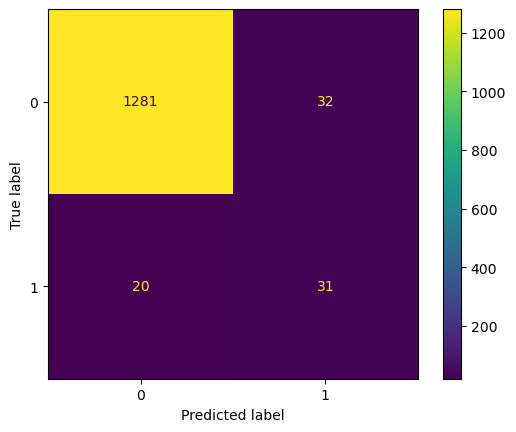

In [43]:
models = {
    "XGBoost": create_xgb_model(),
    "LightGBM": create_lgb_model(),
    "CatBoost": create_cb_model(),
    "RandomForest": create_rf_model()
}

best_model = None
best_f1 = 0
results = []

for name, model in models.items():
    print(f"Training {name} model...")
    model.fit(X_train_scaled, y_train_smote)
    
    y_pred_test = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    acc = accuracy_score(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    results.append({
        "model": name,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": acc,
        "auc": auc
    })
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_model_name = name

for result in results:
    print(result)

print(f"Best Model: {best_model_name}")
print("F1 Score:", best_f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", acc)
print("AUC ROC:", auc)

y_pred_test = best_model.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

## 6. Hyperparameters tuning for best model (LightGBM)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5286, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23783
[LightGBM] [Info] Number of data points in the train set: 10572, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

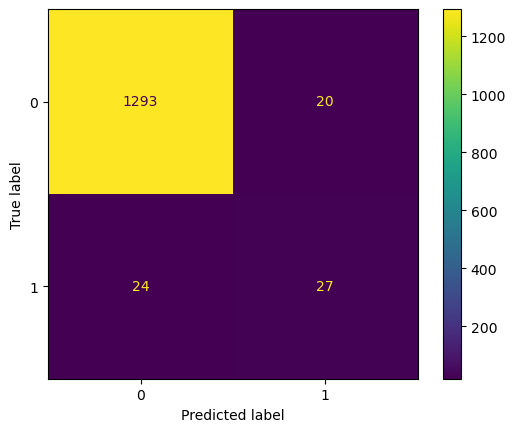

In [44]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for LightGBM
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 500]
}

lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train_smote)

best_params = grid_search.best_params_

print("Best parameters found: ", best_params)

# Train the model with the best parameters
best_lgb_model = lgb.LGBMClassifier(**best_params)
best_lgb_model.fit(X_train_scaled, y_train_smote)

y_pred_test = best_lgb_model.predict(X_test_scaled)
y_pred_prob = best_lgb_model.predict_proba(X_test_scaled)[:, 1]

f1 = f1_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
acc = accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Best Model Performance after Hyperparameter Tuning:")
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", acc)
print("AUC ROC:", auc)

# Plot confusion matrix for the best model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

In [45]:
best_params

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 31}

In [47]:
best_lgb_model

LGBMClassifier(max_depth=10, n_estimators=500)

In [48]:
f1

0.5510204081632654

In [49]:
precision

0.574468085106383

In [50]:
recall

0.5294117647058824

## 7. Feature importances

In [57]:
# Get feature importances
feature_importances = best_lgb_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print top 20 feature importances
top_20_feature_importances = feature_importance_df.head(20)
print("Top 20 Feature Importances:")
print(top_20_feature_importances)

# Print least 20 feature importances
least_20_feature_importances = feature_importance_df.tail(20)
print("Least 20 Feature Importances:")
print(least_20_feature_importances)

Top 20 Feature Importances:
                                         Feature  Importance
73                            Cash Turnover Rate         382
48               Fixed Assets Turnover Frequency         329
50                            Revenue per person         292
13           Interest-bearing debt interest rate         283
11         Research and development expense rate         280
62                   Inventory/Current Liability         252
28                       Total Asset Growth Rate         249
70                   Current Asset Turnover Rate         249
47               Inventory Turnover Rate (times)         238
35                    Total debt/Total net worth         234
61                     Inventory/Working Capital         228
75                        Fixed Assets to Assets         216
71                     Quick Asset Turnover Rate         212
63                 Current Liabilities/Liability         212
8    Non-industry income and expenditure/revenue         

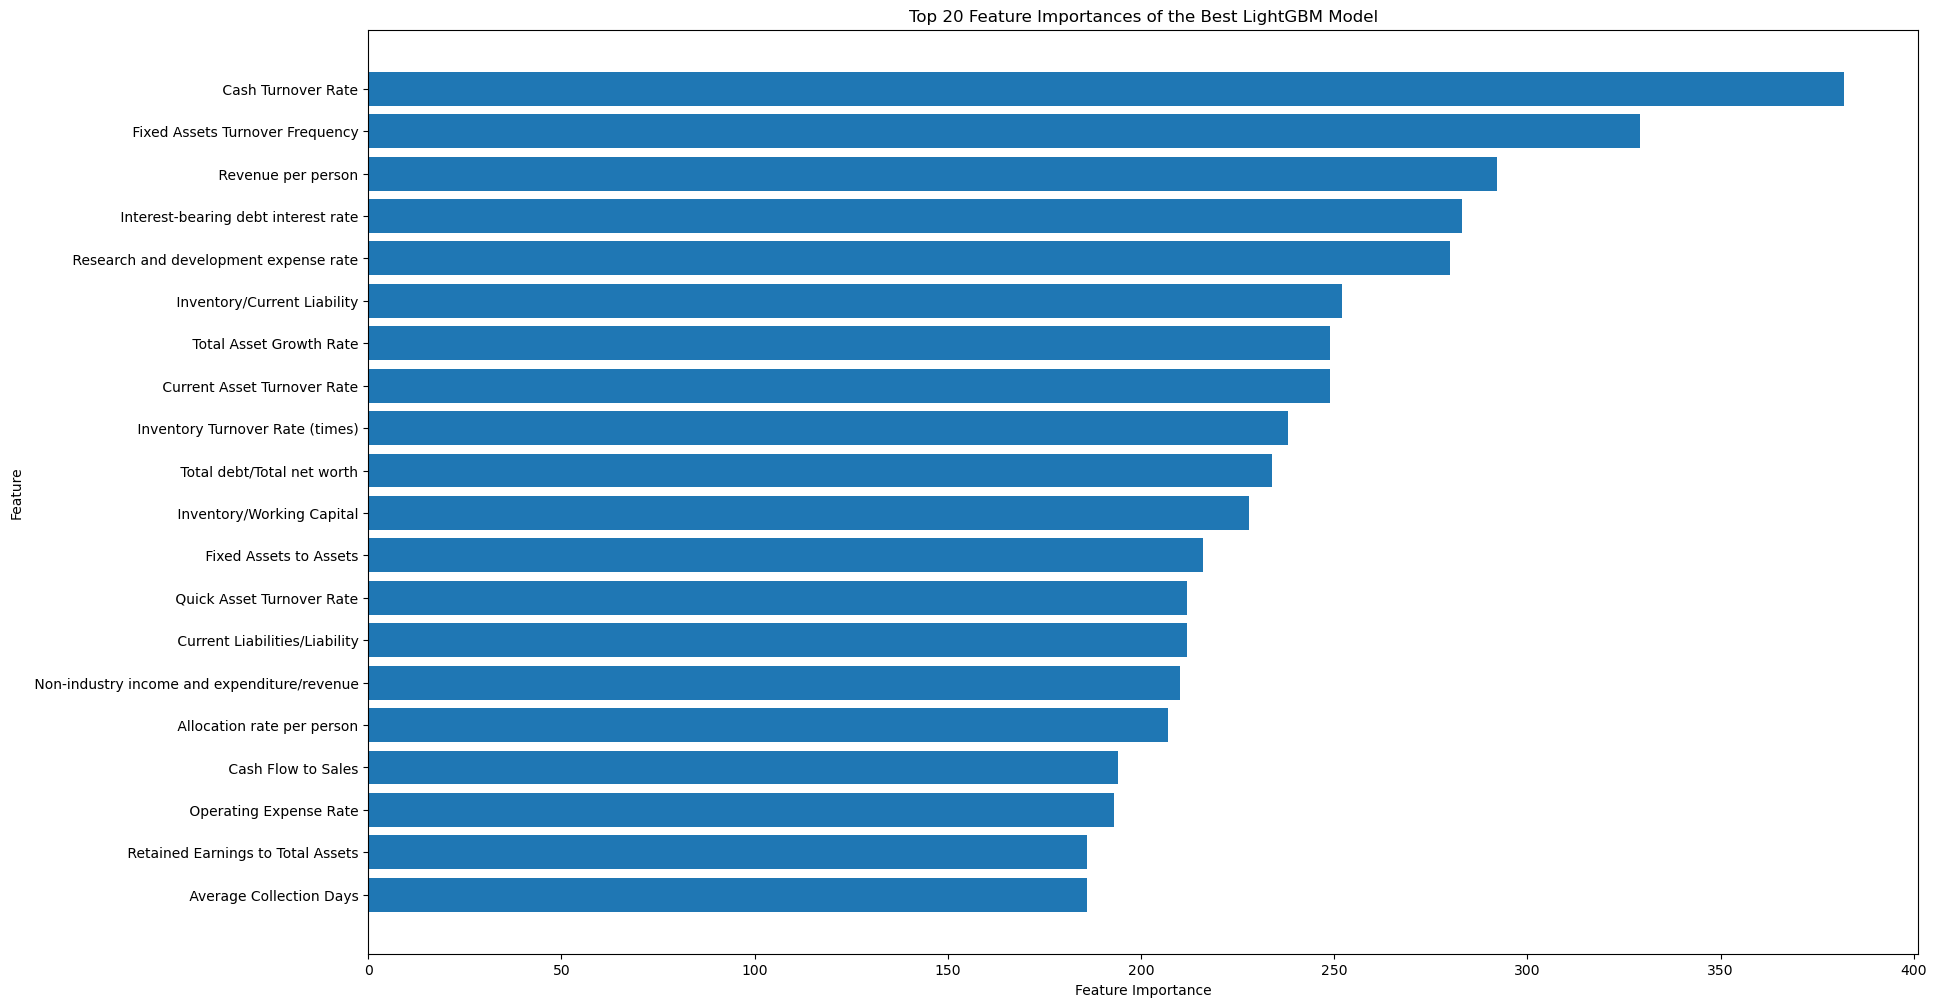

In [58]:
# Plot feature importances
plt.figure(figsize=(20, 12))
plt.barh(top_20_feature_importances['Feature'], top_20_feature_importances['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances of the Best LightGBM Model")
plt.gca().invert_yaxis()
plt.show()

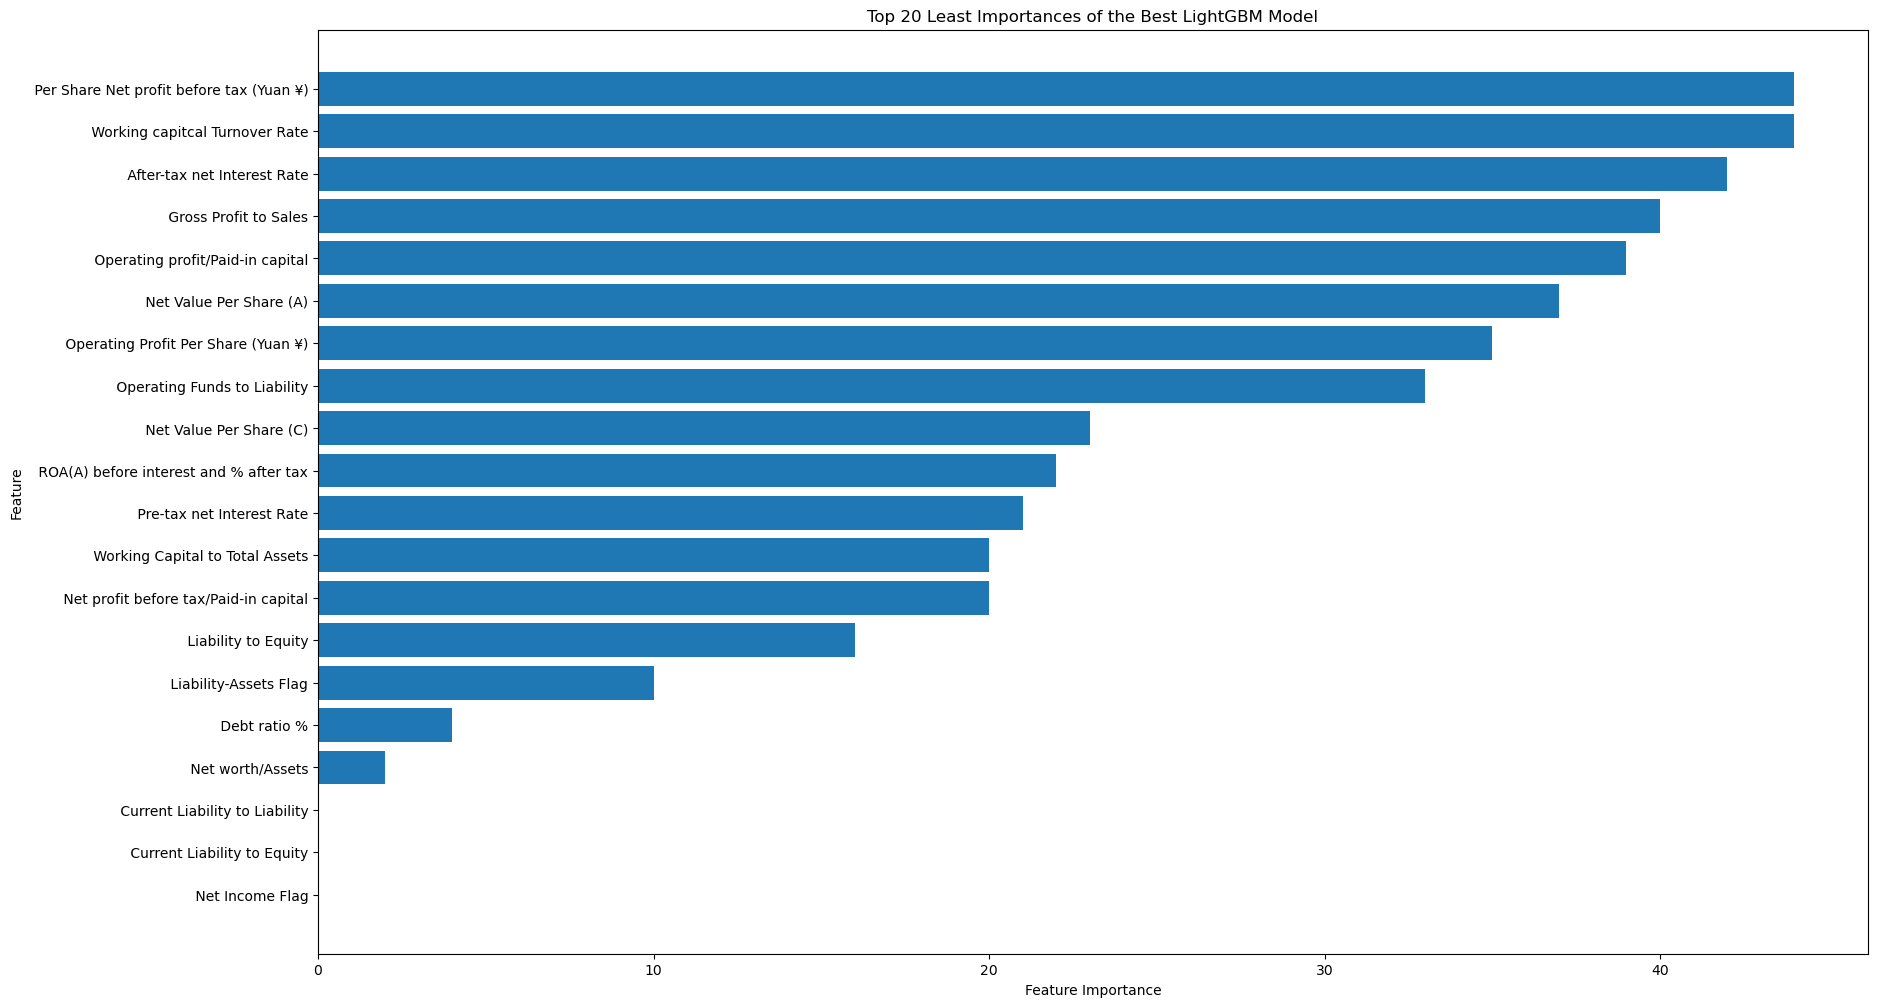

In [59]:
plt.figure(figsize=(20, 12))
plt.barh(least_20_feature_importances['Feature'], least_20_feature_importances['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Least Importances of the Best LightGBM Model")
plt.gca().invert_yaxis()
plt.show()